<a href="https://colab.research.google.com/github/kastei/colab/blob/main/%5Bhomework%5Dsimple_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

***Some parts of the notebook are almost the copy of [ mmta-team course](https://github.com/mmta-team/mmta_fall_2020). Special thanks to mmta-team for making them publicly available. [Original notebook](https://github.com/mmta-team/mmta_fall_2020/blob/master/tasks/01_word_embeddings/task_word_embeddings.ipynb).***

<b> Прочитайте семинар, пожалуйста, для успешного выполнения домашнего задания. В конце ноутка напишите свой вывод. Работа без вывода оценивается ниже.

## Задача поиска схожих по смыслу предложений

Мы будем ранжировать вопросы [StackOverflow](https://stackoverflow.com) на основе семантического векторного представления 

До этого в курсе не было речи про задачу ранжировния, поэтому введем математическую формулировку

## Задача ранжирования(Learning to Rank)

* $X$ - множество объектов
* $X^l = \{x_1, x_2, ..., x_l\}$ - обучающая выборка
<br>На обучающей выборке задан порядок между некоторыми элементами, то есть нам известно, что некий объект выборки более релевантный для нас, чем другой:
* $i \prec j$ - порядок пары индексов объектов на выборке $X^l$ c индексами $i$ и $j$
### Задача:
построить ранжирующую функцию $a$ : $X \rightarrow R$ такую, что
$$i \prec j \Rightarrow a(x_i) < a(x_j)$$

<img src="https://d25skit2l41vkl.cloudfront.net/wp-content/uploads/2016/12/Featured-Image.jpg" width=500, height=450>

### Embeddings

Будем использовать предобученные векторные представления слов на постах Stack Overflow.<br>
[A word2vec model trained on Stack Overflow posts](https://github.com/vefstathiou/SO_word2vec)

In [ ]:
!wget https://zenodo.org/record/1199620/files/SO_vectors_200.bin?download=1

In [ ]:
!pip install gensim==3.8.3

  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.23
    Uninstalling Cython-0.29.23:
      Successfully uninstalled Cython-0.29.23


In [ ]:
!pip install gensim==3.8.3

In [ ]:
from scipy.stats import norm
norm(0,1).pdf(3)

0.0044318484119380075

In [ ]:
from gensim.models.keyedvectors import KeyedVectors
wv_embeddings = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

#### Как пользоваться этими векторами?

Посмотрим на примере одного слова, что из себя представляет embedding

In [ ]:
word = 'dog'
if word in wv_embeddings:
    print(wv_embeddings[word].dtype, wv_embeddings[word].shape)

float32 (200,)


In [ ]:
print(f"Num of words: {len(wv_embeddings.index2word)}")

Num of words: 1787145


Найдем наиболее близкие слова к слову `dog`:

#### Вопрос 1:
* Входит ли слов `cat` топ-5 близких слов к слову `dog`? Какое место? 

In [ ]:
# method most_simmilar
wv_embeddings.most_similar(positive=['dog'], topn=5), wv_embeddings.most_similar(positive=['dog'], topn=26)[25], wv_embeddings.most_similar(positive=['cat'], topn=5)[1]

([('animal', 0.8564180135726929),
  ('dogs', 0.7880866527557373),
  ('mammal', 0.7623804211616516),
  ('cats', 0.7621253728866577),
  ('animals', 0.760793924331665)],
 ('cat', 0.6852341294288635),
 ('dog', 0.6852341890335083))

#### Ответ 1:
в топ5 не входит - 'cat' на 26 месте. 
А если смотреть наоборот, то слово 'dog' на 2 месте в ближайщих словах к слову 'cat' 

### Векторные представления текста

Перейдем от векторных представлений отдельных слов к векторным представлениям вопросов, как к **среднему** векторов всех слов в вопросе. Если для какого-то слова нет предобученного вектора, то его нужно пропустить. Если вопрос не содержит ни одного известного слова, то нужно вернуть нулевой вектор.

In [ ]:
import re

# you can use your tokenizer
# for example, from nltk.tokenize import WordPunctTokenizer

class MySimpleTokenizer:
    def __init__(self):
        pass
    def tokenize(self, text):
        return re.findall('\w+', text.lower())

tokenizer = MySimpleTokenizer()

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
def question_to_vec(question, embeddings, tokenizer, dim=200):
    """
        question: строка
        embeddings: наше векторное представление
        dim: размер любого вектора в нашем представлении
        
        return: векторное представление для вопроса
    """
    result = np.zeros(dim, dtype=np.float32)
    n = 0
    for token in tokenizer.tokenize(question):
         
        if token in embeddings:
            n += 1
            result += embeddings[token]

    if n:
      return result / n
    else:
      return result

Теперь у нас есть метод для создания векторного представления любого предложения.

#### Вопрос 2:
* Какая третья(с индексом 2) компонента вектора предложения `I love neural networks` (округлите до 2 знаков после запятой)?

In [ ]:
round(question_to_vec('I love neural networks', wv_embeddings, tokenizer, dim=200)[2], 2)

-1.29

#### Ответ 2:
-1.29

### Оценка близости текстов

Представим, что мы используем идеальные векторные представления слов. Тогда косинусное расстояние между дублирующими предложениями должно быть меньше, чем между случайно взятыми предложениями. 

Сгенерируем для каждого из $N$ вопросов $R$ случайных отрицательных примеров и примешаем к ним также настоящие дубликаты. Для каждого вопроса будем ранжировать с помощью нашей модели $R + 1$ примеров и смотреть на позицию дубликата. Мы хотим, чтобы дубликат был первым в ранжированном списке.

#### Hits@K
Первой простой метрикой будет количество корректных попаданий для какого-то $K$:
$$ \text{Hits@K} = \frac{1}{N}\sum_{i=1}^N \, [rank\_q_i^{'} \le K],$$
* $\begin{equation*}
[x < 0 ] \equiv 
 \begin{cases}
   1, &x < 0\\
   0, &x \geq 0
 \end{cases}
\end{equation*}$ - индикаторная функция
* $q_i$ - $i$-ый вопрос
* $q_i^{'}$ - его дубликат
* $rank\_q_i^{'}$ - позиция дубликата в ранжированном списке ближайших предложений для вопроса $q_i$.

#### DCG@K
Второй метрикой будет упрощенная DCG метрика, учитывающая порядок элементов в списке путем домножения релевантности элемента на вес равный обратному логарифму номера позиции::
$$ \text{DCG@K} = \frac{1}{N} \sum_{i=1}^N\frac{1}{\log_2(1+rank\_q_i^{'})}\cdot[rank\_q_i^{'} \le K],$$
С такой метрикой модель штрафуется за большой ранк корректного ответа

#### Вопрос 3:
* Максимум `Hits@47 - DCG@1`?

#### Ответ 3:
Максимум разности будет равен 1, если хотя бы 1 дублика меньше 47 позиции и не 1. 
$$  max(\text{Hits@47}) = 1 $$ 
а минимум DCG равен 0, если на первом месте не дубликат 
$$ min(\text{DCG@1}) = 0 $$


<img src='https://hsto.org/files/1c5/edf/dee/1c5edfdeebce4b71a86bdf986d9f88f2.jpg' width=400, height=200>

#### Пример оценок

Вычислим описанные выше метрики для игрушечного примера. 
Пусть
* $N = 1$, $R = 3$
* <font color='green'>"Что такое python?"</font> - вопрос $q_1$
* <font color='red'>"Что такое язык python?"</font> - его дубликат $q_i^{'}$

Пусть модель выдала следующий ранжированный список кандидатов:

1. "Как изучить с++?"
2. <font color='red'>"Что такое язык python?"</font>
3. "Хочу учить Java"
4. "Не понимаю Tensorflow"

$\Rightarrow rank\_q_i^{'} = 2$

Вычислим метрику *Hits@K* для *K = 1, 4*:

- [K = 1] $\text{Hits@1} =  [rank\_q_i^{'} \le 1)] = 0$
- [K = 4] $\text{Hits@4} =  [rank\_q_i^{'} \le 4] = 1$

Вычислим метрику *DCG@K* для *K = 1, 4*:
- [K = 1] $\text{DCG@1} = \frac{1}{\log_2(1+2)}\cdot[2 \le 1] = 0$
- [K = 4] $\text{DCG@4} = \frac{1}{\log_2(1+2)}\cdot[2 \le 4] = \frac{1}{\log_2{3}}$

#### Вопрос 4:
* Вычислите `DCG@10`, если $rank\_q_i^{'} = 9$(округлите до одного знака после запятой)

#### Ответ 4:
$$ DCG@10 = \frac{1}{\log_2(1+9)} = 0.3 $$

In [ ]:
round(1 / np.log2(10), 1)

0.3

### HITS\_COUNT и DCG\_SCORE

Каждая функция имеет два аргумента: $dup\_ranks$ и $k$. $dup\_ranks$ является списком, который содержит рейтинги дубликатов(их позиции в ранжированном списке). Например, $dup\_ranks = [2]$ для примера, описанного выше.

In [ ]:
def hits_count(dup_ranks, k):
    """
        dup_ranks: list индексов дубликатов
        result: вернуть  Hits@k
    """
    hits_value = 0
    for rank in dup_ranks:
        hits_value += 1 if rank <= k else 0
    if len(dup_ranks):
        return hits_value / len(dup_ranks)
    else:
        return hits_value

In [ ]:
def dcg_score(dup_ranks, k):
    """
        dup_ranks: list индексов дубликатов
        result: вернуть DCG@k
    """
    dcg_value = 0
    for rank in dup_ranks:
        dcg_value += 1/np.log2(1 + rank) if rank <= k else 0
    
    if len(dup_ranks):
        return dcg_value / len(dup_ranks)
    else:
        return dcg_value

Протестируем функции. Пусть $N = 1$, то есть один эксперимент. Будем искать копию вопроса и оценивать метрики.

In [ ]:
copy_answers = ["How does the catch keyword determine the type of exception that was thrown",]

# наши кандидаты
candidates_ranking = [["How Can I Make These Links Rotate in PHP",
                       "How does the catch keyword determine the type of exception that was thrown",
                       "NSLog array description not memory address",
                       "PECL_HTTP not recognised php ubuntu"],]
# dup_ranks — позиции наших копий, так как эксперимент один, то этот массив длины 1
dup_ranks = [2]

# вычисляем метрику для разных k
print('Ваш ответ HIT:', [hits_count(dup_ranks, k) for k in range(1, 5)])
print('Ваш ответ DCG:', [round(dcg_score(dup_ranks, k), 5) for k in range(1, 5)])

Ваш ответ HIT: [0.0, 1.0, 1.0, 1.0]
Ваш ответ DCG: [0.0, 0.63093, 0.63093, 0.63093]


У вас должно получиться

In [ ]:
# correct_answers - метрика для разных k
correct_answers = pd.DataFrame([[0, 1, 1, 1], [0, 1 / (np.log2(3)), 1 / (np.log2(3)), 1 / (np.log2(3))]],
                               index=['HITS', 'DCG'], columns=range(1,5))
correct_answers

,1,2,3,4
HITS,0,1.00000,1.00000,1.00000
DCG,0,0.63093,0.63093,0.63093


### Данные
[arxiv link](https://drive.google.com/file/d/1QqT4D0EoqJTy7v9VrNCYD-m964XZFR7_/edit)

`train.tsv` - выборка для обучения.<br> В каждой строке через табуляцию записаны: **<вопрос>, <похожий вопрос>**

`validation.tsv` - тестовая выборка.<br> В каждой строке через табуляцию записаны: **<вопрос>, <похожий вопрос>, <отрицательный пример 1>, <отрицательный пример 2>, ...**

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1QqT4D0EoqJTy7v9VrNCYD-m964XZFR7_' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1QqT4D0EoqJTy7v9VrNCYD-m964XZFR7_" -O 'stackoverflow_similar_questions.zip' && rm -rf /tmp/cookies.txt


--2021-10-03 04:24:04--  https://docs.google.com/uc?export=download&confirm=aCbO&id=1QqT4D0EoqJTy7v9VrNCYD-m964XZFR7_
Resolving docs.google.com (docs.google.com)... 74.125.141.102, 74.125.141.138, 74.125.141.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.141.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-b0-docs.googleusercontent.com/docs/securesc/q8terfpd7c53vuivl1ma9oqgnqr1ng8o/6bm0kpo4chbntmdil9aovd8agaq2bqci/1633235025000/09282986084580850099/05966795513300940750Z/1QqT4D0EoqJTy7v9VrNCYD-m964XZFR7_?e=download [following]
--2021-10-03 04:24:04--  https://doc-0g-b0-docs.googleusercontent.com/docs/securesc/q8terfpd7c53vuivl1ma9oqgnqr1ng8o/6bm0kpo4chbntmdil9aovd8agaq2bqci/1633235025000/09282986084580850099/05966795513300940750Z/1QqT4D0EoqJTy7v9VrNCYD-m964XZFR7_?e=download
Resolving doc-0g-b0-docs.googleusercontent.com (doc-0g-b0-docs.googleusercontent.com)... 172.217.193.132, 2607:f8b0:400c:c03::84
Connectin

In [ ]:
!unzip stackoverflow_similar_questions.zip

Archive:  stackoverflow_similar_questions.zip
   creating: data/
  inflating: data/.DS_Store          
   creating: __MACOSX/
   creating: __MACOSX/data/
  inflating: __MACOSX/data/._.DS_Store  
  inflating: data/train.tsv          
  inflating: data/validation.tsv     


Считайте данные.

In [ ]:
def read_corpus(filename):
    data = []
    for line in open(filename, encoding='utf-8'):
        data.append(line.strip().split('\t'))
    return data

Нам понадобиться только файл validation.

In [ ]:
validation_data = read_corpus('./data/validation.tsv')

Кол-во строк

In [ ]:
len(validation_data)

3760

Размер нескольких первых строк

In [ ]:
for i in range(5):
    print(i + 1, len(validation_data[i]))

1 1001
2 1001
3 1001
4 1001
5 1001


### Ранжирование без обучения

Реализуйте функцию ранжирования кандидатов на основе косинусного расстояния. Функция должна по списку кандидатов вернуть отсортированный список пар (позиция в исходном списке кандидатов, кандидат). При этом позиция кандидата в полученном списке является его рейтингом (первый - лучший). Например, если исходный список кандидатов был [a, b, c], и самый похожий на исходный вопрос среди них - c, затем a, и в конце b, то функция должна вернуть список **[(2, c), (0, a), (1, b)]**.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from copy import deepcopy

In [ ]:
def rank_candidates(question, candidates, embeddings, tokenizer, dim=200):
    """
        question: строка
        candidates: массив строк(кандидатов) [a, b, c]
        result: пары (начальная позиция, кандидат) [(2, c), (0, a), (1, b)]
    """
    question_vec = question_to_vec(question, embeddings, tokenizer, dim)
    candidates_vec = []
    
    for candidat in candidates:
        candidates_vec.append(question_to_vec(candidat, embeddings, tokenizer, dim))

    similarities = cosine_similarity(candidates_vec, [question_vec]).reshape(-1)

    result = []
    for _, x in sorted(zip(similarities, enumerate(candidates)), reverse=True):
        result.append(x)

    return deepcopy(result)

Протестируйте работу функции на примерах ниже. Пусть $N=2$, то есть два эксперимента

In [ ]:
questions = ['converting string to list', 'Sending array via Ajax fails'] 

candidates = [['Convert Google results object (pure js) to Python object', # первый эксперимент
               'C# create cookie from string and send it',
               'How to use jQuery AJAX for an outside domain?'],
              
              ['Getting all list items of an unordered list in PHP',      # второй эксперимент
               'WPF- How to update the changes in list item of a list',
               'select2 not displaying search results']]

In [ ]:
# проверки
q0 = question_to_vec(questions[0], wv_embeddings, tokenizer)
q1 = question_to_vec(questions[1], wv_embeddings, tokenizer)

v0 = []
for candidat in candidates[0]:
    v0.append(question_to_vec(candidat, wv_embeddings, tokenizer))

v1 = []
for candidat in candidates[1]:
    v1.append(question_to_vec(candidat, wv_embeddings, tokenizer))

In [ ]:
cosine_similarity(v0, [q0]).reshape(-1)

array([0.6499193 , 0.550269  , 0.09703707], dtype=float32)

In [ ]:
cosine_similarity(v1, [q1]).reshape(-1)

array([0.46905938, 0.3016457 , 0.36710048], dtype=float32)

In [ ]:
for question, q_candidates in zip(questions, candidates):
        ranks = rank_candidates(question, q_candidates, wv_embeddings, tokenizer)
        print(*ranks, sep='\n')

(1, 'C# create cookie from string and send it')
(0, 'Convert Google results object (pure js) to Python object')
(2, 'How to use jQuery AJAX for an outside domain?')
(0, 'Getting all list items of an unordered list in PHP')
(2, 'select2 not displaying search results')
(1, 'WPF- How to update the changes in list item of a list')


Для первого экперимента вы можете полностью сравнить ваши ответы и правильные ответы. Но для второго эксперимента два ответа на кандидаты будут <b>скрыты</b>(*)

In [ ]:
# должно вывести
results = [[(1, 'C# create cookie from string and send it'),
            (0, 'Convert Google results object (pure js) to Python object'),
            (2, 'How to use jQuery AJAX for an outside domain?')],
           [(*, 'Getting all list items of an unordered list in PHP'), #скрыт
            (*, 'select2 not displaying search results'), #скрыт
            (*, 'WPF- How to update the changes in list item of a list')]] #скрыт

Последовательность начальных индексов вы должны получить `для эксперимента 1`  1, 0, 2.

#### Вопрос 5:
* Какую последовательность начальных индексов вы получили `для эксперимента 2`(перечисление без запятой и пробелов, например, `102` для первого эксперимента?

#### Ответ 5
`021`

Теперь мы можем оценить качество нашего метода. Запустите следующие два блока кода для получения результата. Обратите внимание, что вычисление расстояния между векторами занимает некоторое время (примерно 10 минут). Можете взять для validation 1000 примеров.

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
wv_ranking = []
max_validation_examples = 4000
for i, line in enumerate(tqdm(validation_data)):
    if i == max_validation_examples:
        break
    q, *ex = line
    ranks = rank_candidates(q, ex, wv_embeddings, tokenizer)
    wv_ranking.append([r[0] for r in ranks].index(0) + 1)

In [ ]:
for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

DCG@   1: 0.397 | Hits@   1: 0.397
DCG@   5: 0.494 | Hits@   5: 0.578
DCG@  10: 0.519 | Hits@  10: 0.655
DCG@ 100: 0.564 | Hits@ 100: 0.874
DCG@ 500: 0.578 | Hits@ 500: 0.976
DCG@1000: 0.580 | Hits@1000: 1.000



### Эмбеддинги, обученные на корпусе похожих вопросов

In [ ]:
class MyNormTokenizer():
    import re
    def __init__(self, lemmatizer, stopWords):
        
        self.stopWords = set(stopwords.words('english'))
        self.lemmatizer = lemmatizer
    
    def tokenize(self, text):
        
        # все в нижний регистр
        prepoc_text = text.lower()
        # удалим левые символы, кроме #
        prepoc_text = re.sub('[^A-Za-z0-9# ]', '', prepoc_text)
        # удалим повторяющиеся пробелы
        prepoc_text = re.sub(r'[ ]+', ' ', prepoc_text)
        
        return [self.lemmatizer.lemmatize(word.strip()) for word in prepoc_text.split(' ') if word not in self.stopWords]

In [ ]:
train_data = read_corpus('./data/train.tsv')

In [ ]:
for line in train_data[110:140]:
    print(line)

['How to truncate double number with adding missing zeros at the end', 'Are there any functions for truncating a double in java?']
["Possibility of duplicate Mongo ObjectId's being generated in two different collections?", 'MongoDB query comments along with user information', 'How can I create unique IDs for embedded documents in MongoDB using PHP?']
['maven repository has an invalid certificate', 'How to add aem Uber jar dependency in maven build']
['SimpleXMLElement error but xml is valid', "Start tag expected, '<' not found in sitemap.xml — Not sure what's wrong"]
['XSD documentation as a part of build process', 'How to convert xsd to human readable documentation?']
['Test case for Android SQLite Connection checking', 'Testing database on Android: ProviderTestCase2 or RenamingDelegatingContext?']
['Difference between cursor.count() and cursor.size() in MongoDB', 'Are cursor.size() and cursor.count(true) equivalent?']
['How to remove the fatal error when fetching an assoc array', 'FI

In [ ]:
for line in validation_data[:10]:
    q, *examples = line
    print(q, *examples[:3])

How to print a binary heap tree without recursion? How do you best convert a recursive function to an iterative one? How can i use ng-model with directive in angular js flash: drawing and erasing
How to start PhoneStateListener programmatically? PhoneStateListener and service Java cast object[] to model WCF and What does this mean?
jQuery: Show a div2 when mousenter over div1 is over when hover on div1 depenting on if it is on div2 or not it should act differently How to run selenium in google app engine/cloud? Python Comparing two lists of strings for similarities
Performing async method in a loop in node.js and waiting for result Asynchronous sequence of events using promises Django CMS - not able to upload images through cmsplugin_filer_image Sorting an array by alphabetical order before it is selected by UIPickerView
UE4: output game frames to file Unreal Engine 4: save rendered frame to memory How to show an default text when an item of the TreeView doesn't have subitems simple be

Улучшите качество модели.<br>Склеим вопросы в пары и обучим на них модель Word2Vec из gensim. Выберите размер window. Объясните свой выбор.

Оценив несколько ембеддингов с разным window, получил что лушчее качество дате window = 140

In [ ]:
words = []
for q in tqdm(train_data):
    words.append(tokenizer.tokenize(' '.join(q)))

In [ ]:
from gensim.models import Word2Vec
embeddings_trained = Word2Vec(words, # data for model to train on
                 size=200,           # embedding vector size
                 min_count=5,        # consider words that occured at least 5 times
                 window=2).wv

In [ ]:
wv_ranking = []
max_validation_examples = 1000
for i, line in enumerate(tqdm(validation_data)):
    if i == max_validation_examples:
        break
    q, *ex = line
    ranks = rank_candidates(q, ex, embeddings_trained, tokenizer)
    wv_ranking.append([r[0] for r in ranks].index(0) + 1)

#### tokenizer

In [ ]:
tokenizer = MySimpleTokenizer()

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('wordnet')
nltk.download('stopwords')
stopWords = set(stopwords.words('english'))
wml = nltk.WordNetLemmatizer()

tokenizer = MyNormTokenizer(wml, stopWords)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\George\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\George\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
history_ranking = {}
history_ranking[f'Word2Vec pretrain'] = wv_ranking

In [ ]:
def ranking(model, tokenizer, validation_data, max_validation_examples=1000):
    wv_ranking = []
    for i, line in enumerate(tqdm(validation_data)):
        if i == max_validation_examples:
            break
        q, *ex = line
        ranks = rank_candidates(q, ex, model, tokenizer)
        wv_ranking.append([r[0] for r in ranks].index(0) + 1)

    return wv_ranking

In [ ]:
from gensim.models import Word2Vec

for window in [5, 10, 50, 100, 150, 200]:
    print(f'window = {window}')
    embeddings_trained = Word2Vec(words, # data for model to train on
                 size=200,           # embedding vector size
                 min_count=5,        # consider words that occured at least 5 times
                 window=window).wv
    
    
    history_ranking[f'Word2Vec train window {window} simple'] = ranking(embeddings_trained, tokenizer, 
                                                                        validation_data, 
                                                                        max_validation_examples=4000)


window = 5



window = 10



window = 50



window = 100



window = 150



window = 200


In [ ]:
from gensim.models import Word2Vec

for window in [5, 10, 50, 100, 150, 200]:
    print(f'window = {window}')
    embeddings_trained = Word2Vec(words, # data for model to train on
                 size=200,           # embedding vector size
                 min_count=5,        # consider words that occured at least 5 times
                 window=window).wv
    
    
    history_ranking[f'Word2Vec train window {window} norm'] = ranking(embeddings_trained, tokenizer, 
                                                                      validation_data,
                                                                      max_validation_examples=4000)


window = 5



window = 10



window = 50



window = 100



window = 150



window = 200


In [ ]:
wv_ranking = history_ranking['Word2Vec pretrain']
for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

DCG@   1: 0.397 | Hits@   1: 0.397
DCG@   5: 0.494 | Hits@   5: 0.578
DCG@  10: 0.519 | Hits@  10: 0.655
DCG@ 100: 0.564 | Hits@ 100: 0.874
DCG@ 500: 0.578 | Hits@ 500: 0.976
DCG@1000: 0.580 | Hits@1000: 1.000



In [ ]:
wv_ranking = history_ranking['Word2Vec train window 200 norm']
for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

DCG@   1: 0.423 | Hits@   1: 0.423
DCG@   5: 0.525 | Hits@   5: 0.611
DCG@  10: 0.547 | Hits@  10: 0.681
DCG@ 100: 0.585 | Hits@ 100: 0.860
DCG@ 500: 0.598 | Hits@ 500: 0.961
DCG@1000: 0.602 | Hits@1000: 1.000



### Замечание:
Решить эту задачу с помощью обучения полноценной нейронной сети будет вам предложено, как часть задания в одной из домашних работ по теме "Диалоговые системы".

Напишите свой вывод о полученных результатах.
* Какой принцип токенизации даёт качество лучше и почему?
* Помогает ли нормализация слов?
* Какие эмбеддинги лучше справляются с задачей и почему?
* Почему получилось плохое качество решения задачи?
* Предложите свой подход к решению задачи.

## Вывод:


Лучшее качество дало токенизация с лемматизацией и нормализацией.

Обученная модель с нормализацией и окном больше 100 дало лучшее качество, чем предобученная.

Вероятно, плохое качество получилось из-за недостаточных тренировочных данных.

Можно было еще попробовать при токенизации учитывать слова написанные в camelCase, разбив их и добавив части. Попробовать избавиться от опечаток

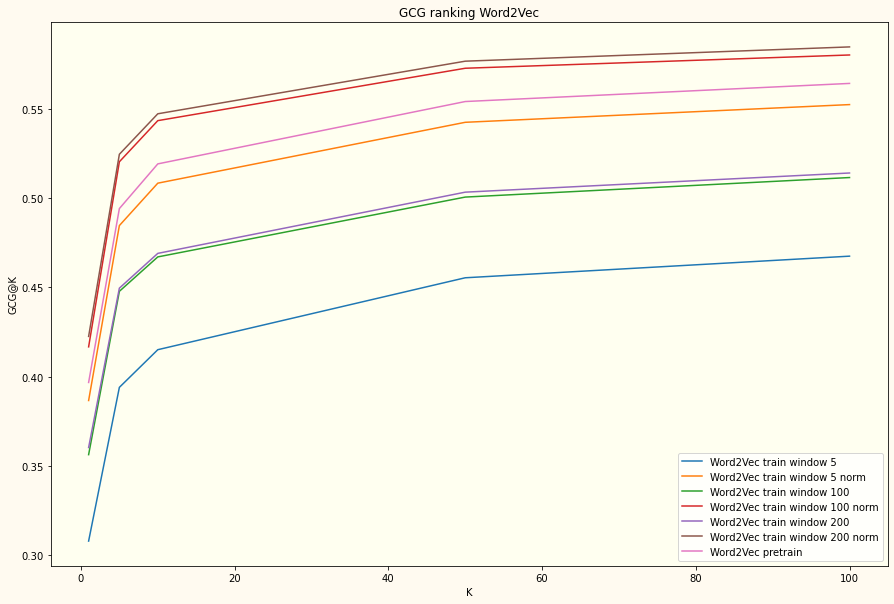

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


fig, ax = plt.subplots(figsize=(15, 10))
fig.set_facecolor('floralwhite')
ax.set_facecolor('ivory')

ax.set_title('GCG ranking Word2Vec')
ax.set_ylabel('GCG@K')
ax.set_xlabel('K')

x = [1, 5, 10, 50, 100]

for window in [5, 100, 200]:
    y = []
    for k in x:
        y.append(dcg_score(history_ranking[f'Word2Vec train window {window} simple'], k))

    plt.plot(x, y, label=f'Word2Vec train window {window}')
    
    y = []
    for k in x:
        y.append(dcg_score(history_ranking[f'Word2Vec train window {window} norm'], k))

    plt.plot(x, y, label=f'Word2Vec train window {window} norm')
    

y = []
for k in x:
    y.append(dcg_score(history_ranking[f'Word2Vec pretrain'], k))

plt.plot(x, y, label=f'Word2Vec pretrain')

plt.legend()

plt.show()